In [33]:
import os
import numpy as np
import xarray as xr
import earthaccess
from datetime import datetime, timedelta
import pickle
from tqdm import tqdm  # New for progress bar

# Authenticate
auth = earthaccess.login(persist=True)

# Parameters
bbox = (-83.62, 41.34, -82, 42.27)      # (lon_min, lat_min, lon_max, lat_max)
res = 0.01  # grid resolution in degrees
start_date = datetime(2024, 5, 17)
end_date = datetime(2025, 5, 23)
window_size = 7
decay = 0.8  # Exponential decay factor

# Ensure data directory exists
os.makedirs("../Data/", exist_ok=True)

# Output grid
lat_bins = np.arange(bbox[1], bbox[3] + res, res)
lon_bins = np.arange(bbox[0], bbox[2] + res, res)
lat_centers = 0.5 * (lat_bins[:-1] + lat_bins[1:])
lon_centers = 0.5 * (lon_bins[:-1] + lon_bins[1:])
nlat, nlon = len(lat_centers), len(lon_centers)

# Determine all unique wavelengths from a reference file
print("Retrieving wavelength list from a reference file...")
search_ref = earthaccess.search_data(
    short_name="PACE_OCI_L2_AOP",
    temporal=("2024-06-01", "2024-06-05"),  # A small window likely to have data
    bounding_box=bbox,
)
if not search_ref:
    raise RuntimeError("No reference files found to retrieve wavelengths.")
ref_file = earthaccess.download(search_ref, "../Data/")[0]
wave_all = xr.open_dataset(ref_file, group="sensor_band_parameters")["wavelength_3d"].data
num_channels = len(wave_all)
print(f"Found {num_channels} channels.")

# Prepare list of days
total_days = (end_date - start_date).days + 1
ndarray_all = np.full((total_days, nlat, nlon, num_channels), np.nan, dtype=np.float32)

# Process day by day
for day_idx in range(total_days):
    current_date = start_date + timedelta(days=day_idx)
    window_start = current_date - timedelta(days=window_size - 1)
    window_end = current_date
    print(f"\nProcessing {current_date.date()} (window {window_start.date()} to {window_end.date()})")

    # Search for data in window
    results = earthaccess.search_data(
        short_name="PACE_OCI_L2_AOP",
        temporal=(window_start.strftime("%Y-%m-%d"), window_end.strftime("%Y-%m-%d")),
        bounding_box=bbox,
    )

    if not results:
        print("No data found for this window. Skipping to next date.")
        continue

    paths = earthaccess.download(results, "../Data/")
    if not paths:
        print("No files downloaded for this window. Skipping to next date.")
        continue

    # Initialize sum and weight arrays for each channel
    sum_all = np.zeros((num_channels, nlat, nlon))
    weight_all = np.zeros((num_channels, nlat, nlon))

    # Process files and apply exponential decay
    for path in paths:
        print(f"Processing {path}")
        try:
            nav = xr.open_dataset(path, group="navigation_data")
            lat = nav["latitude"].values
            lon = nav["longitude"].values

            rrs_ds = xr.open_dataset(path, group="geophysical_data")["Rrs"]
            rrs_ds = rrs_ds.assign_coords(wavelength_3d=wave_all)

            # Get file date for decay weight
            base = os.path.basename(path)
            date_str = base.split(".")[1][:8]  # Updated pattern: 'PACE_OCI.20240512T164859.L2.OC_AOP.V3_0.nc'
            file_date = datetime.strptime(date_str, "%Y%m%d")
            delta_days = (window_end - file_date).days
            weight = decay ** delta_days if delta_days >= 0 else 0

            print(f"Applying weight {weight:.4f} for file date {file_date.date()}")

            # Progress bar for channels
            for ch_idx, wl in tqdm(list(enumerate(wave_all)), desc="Channels", leave=False):
                band = rrs_ds.sel(wavelength_3d=wl, method="nearest").values
                mask = (
                    np.isfinite(band) &
                    (lat >= bbox[1]) & (lat <= bbox[3]) &
                    (lon >= bbox[0]) & (lon <= bbox[2])
                )
                lat_valid = lat[mask]
                lon_valid = lon[mask]
                val_valid = band[mask]

                lat_idx = np.searchsorted(lat_bins, lat_valid) - 1
                lon_idx = np.searchsorted(lon_bins, lon_valid) - 1

                for j in range(len(val_valid)):
                    if 0 <= lat_idx[j] < nlat and 0 <= lon_idx[j] < nlon:
                        sum_all[ch_idx, lat_idx[j], lon_idx[j]] += val_valid[j] * weight
                        weight_all[ch_idx, lat_idx[j], lon_idx[j]] += weight

        except Exception as e:
            print(f"Failed to process {path}: {e}")

    # Finalize averaged values
    with np.errstate(invalid="ignore", divide="ignore"):
        avg_all = sum_all / weight_all
        avg_all[weight_all == 0] = np.nan  # Set pixels with no data to NaN

    # Save to main array
    ndarray_all[day_idx] = np.transpose(avg_all, (1, 2, 0))  # (nlat, nlon, num_channels)

    # Remove old files outside of 7-day window
    delete_date = (current_date - timedelta(days=window_size)).strftime('%Y%m%d')
    for fname in os.listdir("../Data/"):
        if delete_date in fname and fname.endswith(".nc"):
            try:
                os.remove(os.path.join("../Data/", fname))
                print(f"Deleted old file: {fname}")
            except Exception as e:
                print(f"Could not delete {fname}: {e}")

# Save as .npy
np.save("../Images/composite_data.npy", ndarray_all)
print("\nSaved full 4D composite data array to '../Images/composite_data.npy'.")

# Save metadata
metadata = {
    "wavelengths": wave_all,
    "lat": lat_centers,
    "lon": lon_centers,
}
with open("../Images/composite_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)
print("Saved metadata (wavelengths, lat, lon) to '../Images/composite_metadata.pkl'.")


Retrieving wavelength list from a reference file...


QUEUEING TASKS | : 100%|████████████████████████| 9/9 [00:00<00:00, 2089.61it/s]
PROCESSING TASKS | : 100%|█████████████████████| 9/9 [00:00<00:00, 45153.99it/s]
COLLECTING RESULTS | : 100%|██████████████████| 9/9 [00:00<00:00, 118334.60it/s]


Found 172 channels.

Processing 2024-05-17 (window 2024-05-11 to 2024-05-17)


QUEUEING TASKS | : 100%|██████████████████████| 13/13 [00:00<00:00, 1534.47it/s]
PROCESSING TASKS | :  46%|██████████▌            | 6/13 [00:16<00:19,  2.76s/it]


KeyboardInterrupt: 

In [28]:
wave = xr.open_dataset(paths[0], group="sensor_band_parameters")["wavelength_3d"].data
indices = np.where(wave == 450)
indices[0]

array([42])

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

def generate_day_images(n, r_idx=113, g_idx=84, b_idx=42):
    """
    Generate individual true-color images for the first n days in the composite data.
    
    Args:
        n (int): Number of days to generate images for.
        r_idx (int): Index of the wavelength to use for red channel.
        g_idx (int): Index of the wavelength to use for green channel.
        b_idx (int): Index of the wavelength to use for blue channel.
    """
    # Load data
    data_path = "../Images/composite_data.npy"
    meta_path = "../Images/composite_metadata.pkl"
    if not os.path.exists(data_path) or not os.path.exists(meta_path):
        print("Required files not found. Run the composite script first.")
        return
    
    data = np.load(data_path)
    print("data.shape", data.shape)
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    
    lat = meta["lat"]
    lon = meta["lon"]
    wavelengths = meta["wavelengths"]

    num_days = data.shape[0]
    n = min(n, num_days)  # Ensure n doesn't exceed available data

    # Normalize Rrs data (assumed 0-0.03)
    def normalize(arr, vmin=0, vmax=0.03):
        return np.clip((arr - vmin) / (vmax - vmin), 0, 1)

    for day_idx in range(n):
        daily_data = data[day_idx]  # shape (h, w, c)

        if np.isnan(daily_data).all():
            print(f"Day {day_idx + 1} has no valid data. Skipping.")
            continue

        r = normalize(daily_data[:, :, r_idx])
        g = normalize(daily_data[:, :, g_idx])
        b = normalize(daily_data[:, :, b_idx])

        rgb = np.stack([r, g, b], axis=-1)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.imshow(rgb, origin="lower", extent=[lon.min(), lon.max(), lat.min(), lat.max()])
        plt.title(f"True-Color Image - Day {day_idx + 1}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()

        out_path = f"../Images/day_{day_idx + 1:03d}.png"
        plt.savefig(out_path)
        plt.close()
        print(f"Saved image: {out_path}")

    return data


In [30]:
data = generate_day_images(5)

data.shape (7, 93, 163, 172)
Saved image: ../Images/day_001.png
Saved image: ../Images/day_002.png
Saved image: ../Images/day_003.png
Saved image: ../Images/day_004.png
Saved image: ../Images/day_005.png


In [18]:
data[3][45][100]

array([-8.2559995e-03, -7.8280009e-03, -7.3119998e-03, -7.1699992e-03,
       -7.0079975e-03, -6.7439973e-03, -6.7179985e-03, -6.3220002e-03,
       -5.9579983e-03, -5.6420006e-03, -5.2299984e-03, -4.8840009e-03,
       -4.6500005e-03, -4.6319999e-03, -4.3959990e-03, -3.9980002e-03,
       -3.8300010e-03, -3.6699998e-03, -3.5099986e-03, -3.3419989e-03,
       -2.9839985e-03, -2.4820007e-03, -2.3019984e-03, -2.2940002e-03,
       -2.2320002e-03, -2.0339973e-03, -1.8359981e-03, -1.7080009e-03,
       -1.4999993e-03, -1.2499989e-03, -1.0100007e-03, -8.4199762e-04,
       -6.1799958e-04, -3.7799776e-04, -6.2000006e-05,  2.5200099e-04,
        4.4400248e-04,  6.3600019e-04,  8.6800015e-04,  1.0640025e-03,
        1.3400019e-03,  1.6820022e-03,  1.9000024e-03,  2.1320023e-03,
        2.3780018e-03,  2.5740007e-03,  2.7780011e-03,  2.9119998e-03,
        3.1060018e-03,  3.3279995e-03,  3.5420023e-03,  3.7740022e-03,
        3.9600022e-03,  4.1620024e-03,  4.3679997e-03,  4.5160018e-03,
      

In [2]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import earthaccess
from datetime import datetime, timedelta

# Authenticate
auth = earthaccess.login(persist=True)

# Parameters
selected_wavelengths = [645, 555, 450]  # R, G, B
bbox = (-83.62, 41.34, -82, 42.27)      # (lon_min, lat_min, lon_max, lat_max)
res = 0.01  # grid resolution in degrees
start_date = datetime(2024, 5, 17)
end_date = datetime(2025, 5, 23)

# Ensure output directories exist
os.makedirs("../Images/", exist_ok=True)
os.makedirs("../Data/", exist_ok=True)

# Output grid
lat_bins = np.arange(bbox[1], bbox[3] + res, res)
lon_bins = np.arange(bbox[0], bbox[2] + res, res)
lat_centers = 0.5 * (lat_bins[:-1] + lat_bins[1:])
lon_centers = 0.5 * (lon_bins[:-1] + lon_bins[1:])
nlat, nlon = len(lat_centers), len(lon_centers)

# Iterate through each day
current_date = start_date
while current_date <= end_date:
    window_start = current_date - timedelta(days=4)
    window_end = current_date
    print(f"Processing window: {window_start.date()} to {window_end.date()}")

    results = earthaccess.search_data(
        short_name="PACE_OCI_L2_AOP",
        temporal=(window_start.strftime("%Y-%m-%d"), window_end.strftime("%Y-%m-%d")),
        bounding_box=bbox,
    )

    if not results:
        print(f"No data for {window_end.strftime('%Y-%m-%d')}. Skipping.")
        current_date += timedelta(days=1)
        continue

    paths = earthaccess.download(results, "../Data/")

    if not paths:
        print(f"No files downloaded for {window_end.strftime('%Y-%m-%d')}. Skipping.")
        current_date += timedelta(days=1)
        continue

    # Initialize sum and count arrays
    sum_rgb = np.zeros((3, nlat, nlon))
    count_rgb = np.zeros((3, nlat, nlon))

    try:
        wave = xr.open_dataset(paths[0], group="sensor_band_parameters")["wavelength_3d"].data
    except Exception as e:
        print(f"Failed to read wavelength data: {e}")
        current_date += timedelta(days=1)
        continue

    # Process each file
    for path in paths:
        print(f"Processing {path}")
        try:
            rrs_ds = xr.open_dataset(path, group="geophysical_data")["Rrs"]
            rrs_ds = rrs_ds.assign_coords(wavelength_3d=wave)

            nav = xr.open_dataset(path, group="navigation_data")
            lat = nav["latitude"].values
            lon = nav["longitude"].values

            for b, wl in enumerate(selected_wavelengths):
                band = rrs_ds.sel(wavelength_3d=wl, method="nearest").values
                mask = (
                    np.isfinite(band) &
                    (lat >= bbox[1]) & (lat <= bbox[3]) &
                    (lon >= bbox[0]) & (lon <= bbox[2])
                )

                lat_valid = lat[mask]
                lon_valid = lon[mask]
                val_valid = band[mask]

                lat_idx = np.searchsorted(lat_bins, lat_valid) - 1
                lon_idx = np.searchsorted(lon_bins, lon_valid) - 1

                for j in range(len(val_valid)):
                    if 0 <= lat_idx[j] < nlat and 0 <= lon_idx[j] < nlon:
                        sum_rgb[b, lat_idx[j], lon_idx[j]] += val_valid[j]
                        count_rgb[b, lat_idx[j], lon_idx[j]] += 1
        except Exception as e:
            print(f"Failed to process {path}: {e}")

    # Compute mean reflectance
    with np.errstate(invalid='ignore', divide='ignore'):
        mean_rgb = sum_rgb / count_rgb
        mean_rgb = np.nan_to_num(mean_rgb, nan=0.0)

    # Normalize reflectance for display (Rrs units are ~0–0.03)
    def normalize(arr, vmin=0, vmax=0.03):
        return np.clip((arr - vmin) / (vmax - vmin), 0, 1)

    r = normalize(mean_rgb[0])
    g = normalize(mean_rgb[1])
    b = normalize(mean_rgb[2])
    rgb = np.stack([r, g, b], axis=-1)

    # Save true color image
    plt.figure(figsize=(10, 6))
    plt.imshow(rgb, origin="lower", extent=[bbox[0], bbox[2], bbox[1], bbox[3]])
    plt.title(f"5-Day Composite Ending {window_end.strftime('%Y-%m-%d')}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.tight_layout()
    out_path = f"../Images/{window_end.strftime('%Y%m%d')}.png"
    plt.savefig(out_path)
    plt.close()
    print(f"Saved image: {out_path}")

    # Clean up only the earliest date in window
    delete_date = window_start.strftime('%Y%m%d')
    for fname in os.listdir("../Data/"):
        if delete_date in fname and fname.endswith(".nc"):
            try:
                os.remove(os.path.join("../Data/", fname))
                print(f"Deleted old file: {fname}")
            except Exception as e:
                print(f"Could not delete {fname}: {e}")

    current_date += timedelta(days=1)


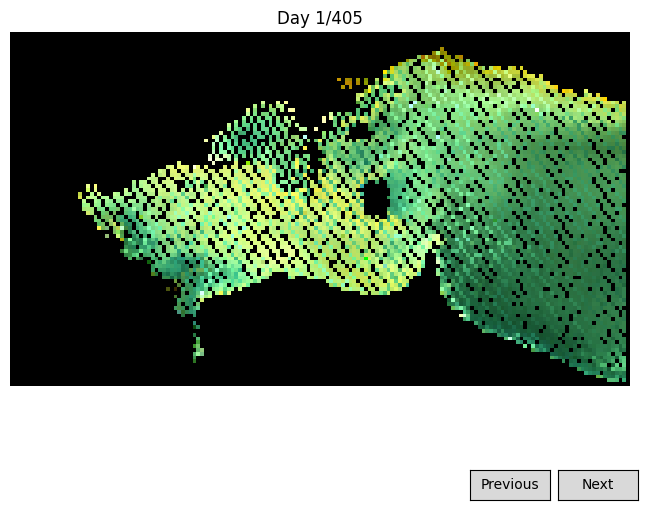

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

# --- Load the data ---
data_path = "../Images/composite_data_PACE_full.npy"
ndarray_all = np.load(data_path)  # shape: (n, h, w, c)

# --- Extract RGB channels ---
# Channel indices
R_idx, G_idx, B_idx = 113, 84, 42
RGB_data = ndarray_all[..., [R_idx, G_idx, B_idx]]  # shape: (n, h, w, 3)

# --- Normalize for display (per image) ---
def normalize_image(img):
    img = np.nan_to_num(img, nan=0.0)
    min_val, max_val = np.percentile(img, 1), np.percentile(img, 99)
    img = np.clip((img - min_val) / (max_val - min_val + 1e-8), 0, 1)
    return img

RGB_data_normalized = np.array([normalize_image(RGB_data[i]) for i in range(RGB_data.shape[0])])

# --- Viewer tool ---
class ImageViewer:
    def __init__(self, images):
        self.images = images
        self.n_images = images.shape[0]
        self.index = 0

        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.img_display = self.ax.imshow(self.images[self.index])
        self.ax.set_title(f"Day {self.index+1}/{self.n_images}")
        self.ax.axis('off')

        axprev = plt.axes([0.7, 0.01, 0.1, 0.05])
        axnext = plt.axes([0.81, 0.01, 0.1, 0.05])
        self.bnext = Button(axnext, 'Next')
        self.bprev = Button(axprev, 'Previous')
        self.bnext.on_clicked(self.next)
        self.bprev.on_clicked(self.prev)

        plt.show()

    def update(self):
        self.img_display.set_data(self.images[self.index])
        self.ax.set_title(f"Day {self.index+1}/{self.n_images}")
        self.fig.canvas.draw_idle()

    def next(self, event):
        self.index = (self.index + 1) % self.n_images
        self.update()

    def prev(self, event):
        self.index = (self.index - 1) % self.n_images
        self.update()

# --- Run the viewer ---
viewer = ImageViewer(RGB_data_normalized)
